In [1]:
import pandas as pd
import numpy as np
import math
import datetime as dt

import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)

In [2]:
# Loading Dataset and remainig its columns

data=pd.read_csv('../input/BTC-USD.csv')
data = data.rename(columns={'Date': 'date','Open':'open','High':'high','Low':'low','Close':'close',
                                'Adj Close':'adj_close','Volume':'volume'})

In [3]:
# Displaying first 5 rows of the dataset

data.head()

,date,open,high,low,close,adj_close,volume
0,2018-08-26,6754.640137,6774.750000,6620.750000,6707.259766,6707.259766,3295500000
1,2018-08-27,6710.799805,6884.640137,6689.709961,6884.640137,6884.640137,4019000000
2,2018-08-28,6891.080078,7109.560059,6882.339844,7096.279785,7096.279785,4659940000
3,2018-08-29,7091.709961,7113.299805,6970.819824,7047.160156,7047.160156,4145880000
4,2018-08-30,7043.759766,7072.689941,6834.689941,6978.229980,6978.229980,4463250000


In [4]:
# Displaying Last 5 rows of the dataset

data.tail()

,date,open,high,low,close,adj_close,volume
1822,2023-08-22,26130.748047,26135.507813,25520.728516,26031.656250,26031.656250,14503820706
1823,2023-08-23,26040.474609,26786.898438,25804.998047,26431.640625,26431.640625,16985265785
1824,2023-08-24,26431.519531,26554.910156,25914.925781,26162.373047,26162.373047,12871532023
1825,2023-08-25,26163.679688,26248.103516,25786.812500,26047.667969,26047.667969,12406045118
1826,2023-08-26,26046.810547,26081.794922,26032.876953,26043.894531,26043.894531,11226943488


In [5]:
data.shape

(1827, 7)

In [6]:
data.describe()

,open,high,low,close,adj_close,volume
count,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1.827000e+03
mean,22632.621722,23155.935625,22058.939758,22641.010408,22641.010408,2.815360e+10
std,16468.640194,16894.500945,15971.538888,16460.222147,16460.222147,1.886294e+10
min,3236.274658,3275.377930,3191.303467,3236.761719,3236.761719,3.064030e+09
25%,8788.635254,8927.100586,8635.734375,8795.703125,8795.703125,1.615568e+10
50%,19139.000000,19390.500000,18721.285156,19142.382813,19142.382813,2.537256e+10
75%,33767.375000,34778.076172,32265.797851,33734.515625,33734.515625,3.613765e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


In [7]:
data.isnull().sum()

date         0
open         0
high         0
low          0
close        0
adj_close    0
volume       0
dtype: int64

In [8]:
data['date'] = pd.to_datetime(data.date)
data.head()

,date,open,high,low,close,adj_close,volume
0,2018-08-26,6754.640137,6774.750000,6620.750000,6707.259766,6707.259766,3295500000
1,2018-08-27,6710.799805,6884.640137,6689.709961,6884.640137,6884.640137,4019000000
2,2018-08-28,6891.080078,7109.560059,6882.339844,7096.279785,7096.279785,4659940000
3,2018-08-29,7091.709961,7113.299805,6970.819824,7047.160156,7047.160156,4145880000
4,2018-08-30,7043.759766,7072.689941,6834.689941,6978.229980,6978.229980,4463250000


In [9]:
print("Starting date: ",data.iloc[0][0])
print("Ending date: ", data.iloc[-1][0])
print("Duration: ", data.iloc[-1][0]-data.iloc[0][0])

Starting date:  2018-08-26 00:00:00
Ending date:  2023-08-26 00:00:00
Duration:  1826 days 00:00:00


In [10]:
y_overall=data
y_overall.drop(y_overall[['adj_close','volume']],axis=1)

,date,open,high,low,close
0,2018-08-26,6754.640137,6774.750000,6620.750000,6707.259766
1,2018-08-27,6710.799805,6884.640137,6689.709961,6884.640137
2,2018-08-28,6891.080078,7109.560059,6882.339844,7096.279785
3,2018-08-29,7091.709961,7113.299805,6970.819824,7047.160156
4,2018-08-30,7043.759766,7072.689941,6834.689941,6978.229980
...,...,...,...,...,...
1822,2023-08-22,26130.748047,26135.507813,25520.728516,26031.656250
1823,2023-08-23,26040.474609,26786.898438,25804.998047,26431.640625
1824,2023-08-24,26431.519531,26554.910156,25914.925781,26162.373047
1825,2023-08-25,26163.679688,26248.103516,25786.812500,26047.667969


In [11]:
monthvise= y_overall.groupby(y_overall['date'].dt.strftime('%B'))[['open','close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)

In [12]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(y_overall, x=y_overall.date, y=[y_overall['open'], y_overall['close'], 
                                          y_overall['high'], y_overall['low']],
             labels={'Date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

In [13]:
 closedf = data[['date','close']]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (1827, 2)


In [14]:
closedf = closedf[closedf['date'] > '2022-09-13']
close_stock = closedf.copy()
print("Total data for prediction: ",closedf.shape[0])

Total data for prediction:  347


In [15]:
del closedf['date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(347, 1)


In [16]:
training_size=int(len(closedf)*0.70)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (242, 1)
test_data:  (105, 1)


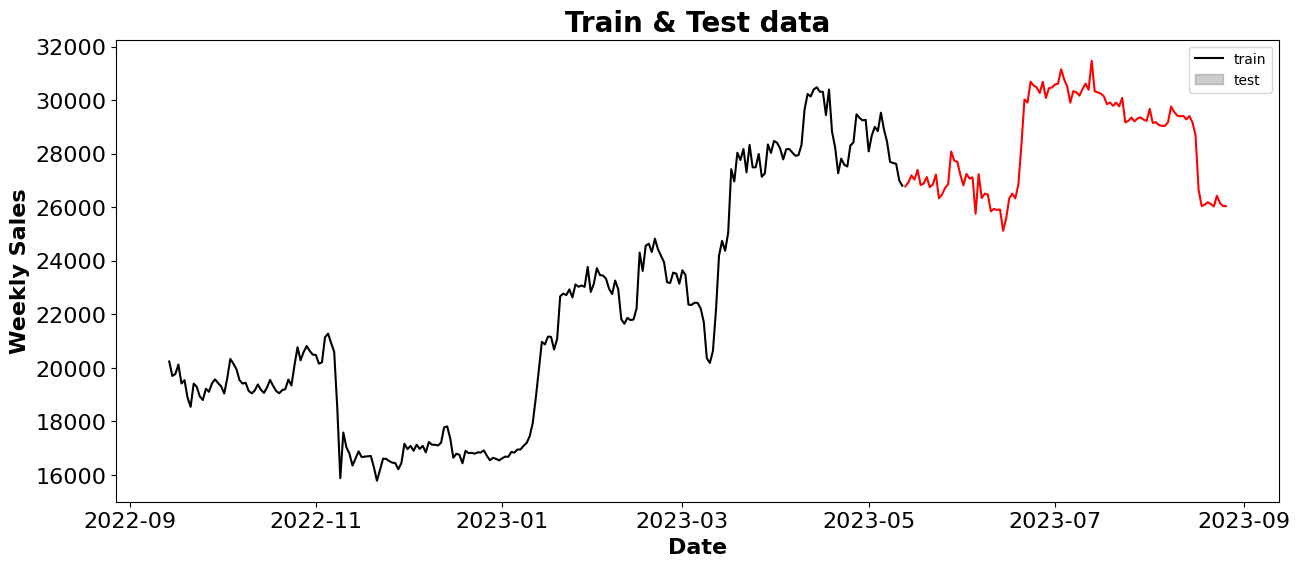

In [17]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = close_stock['date'][:241], y = close_stock['close'][:241], color = 'black')
sns.lineplot(x = close_stock['date'][241:], y = close_stock['close'][241:], color = 'red')

# Formatting
ax.set_title('Train & Test data', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Weekly Sales', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.legend(loc='upper right' ,labels = ('train', 'test'))
plt.show()


In [18]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [19]:
time_step = 21
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (220, 21)
y_train:  (220,)
X_test:  (83, 21)
y_test (83,)


In [20]:
# Biulding Model

my_model = XGBRegressor(n_estimators=1000)
my_model.fit(X_train, y_train, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [21]:
predictions = my_model.predict(X_test)
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions))))

Mean Absolute Error - MAE : 0.07161471544795724
Root Mean squared Error - RMSE : 0.07960440271011592


In [22]:
train_predict=my_model.predict(X_train)
test_predict=my_model.predict(X_test)

train_predict = train_predict.reshape(-1,1)
test_predict = test_predict.reshape(-1,1)

print("Train data prediction:", train_predict.shape)
print("Test data prediction:", test_predict.shape)

Train data prediction: (220, 1)
Test data prediction: (83, 1)


In [23]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [24]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])

plotdf = pd.DataFrame({'date': close_stock['date'],
                       'original_close': close_stock['close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Close price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (347, 1)
Test predicted data:  (347, 1)


In [25]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 10
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        
        yhat = my_model.predict(x_input)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        yhat = my_model.predict(x_input)
        
        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())
        
        i=i+1
        
print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  10


In [26]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
[22 23 24 25 26 27 28 29 30 31]


In [27]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 15 days close price','Predicted next 10 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Close price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 10 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [28]:
my_model.save_model("XGBoost_model.json")
my_model=closedf.tolist()
my_model.extend((np.array(lst_output).reshape(-1,1)).tolist())
my_model=scaler.inverse_transform(my_model).reshape(1,-1).tolist()[0]

names = cycle(['Close Price'])

fig = px.line(my_model,labels={'value': 'Close price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()